In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pydrake.geometry.optimization import GraphOfConvexSetsOptions, HPolyhedron, Point
from pydrake.planning import GcsTrajectoryOptimization
from scipy.spatial import ConvexHull

# Environment setup

In [2]:
sr2 = np.sqrt(2)

# obstacles
obstacles = [
    np.array(
        [
            [3.4, 2.6],
            [3.4, 4.6],
            [2.4, 4.6],
            [2.4, 2.6],
            [1.4, 2.2],
            [3.8, 0.2],
            [4.8, 1.2],
        ]
    ),
    np.array([[1.4, 2.8], [2.2, 2.8], [2.2, 4.6], [1.4, 4.6]]),
    np.array([[1.0, 2.6], [1.0, 5.0], [0.4, 5.0], [0.4, 2.6]]),
    np.array([[1.0, 2.4], [1.0, 0.0], [0.4, 0.0], [0.4, 2.4]]),
    np.array([[3.8, 3.0], [3.8, 5.0], [4.4, 5.0], [4.4, 3.0]]),
    np.array([[3.8, 2.8], [3.8, 2.6], [5.0, 2.6], [5.0, 2.8]]),
]

# vertices of the safe regions
vertices = [
    np.array([[0.4, 0.0], [0.4, 5.0], [0.0, 5.0], [0.0, 0.0]]),
    np.array([[0.4, 2.4], [1.0, 2.4], [1.0, 2.6], [0.4, 2.6]]),
    np.array([[1.4, 2.2], [1.4, 4.6], [1.0, 4.6], [1.0, 2.2]]),
    np.array([[1.4, 2.2], [2.4, 2.6], [2.4, 2.8], [1.4, 2.8]]),
    np.array([[2.2, 2.8], [2.4, 2.8], [2.4, 4.6], [2.2, 4.6]]),
    np.array([[1.4, 2.2], [1.0, 2.2], [1.0, 0.0], [3.8, 0.0], [3.8, 0.2]]),
    np.array([[3.8, 4.6], [3.8, 5.0], [1.0, 5.0], [1.0, 4.6]]),
    np.array([[5.0, 0.0], [5.0, 1.2], [4.8, 1.2], [3.8, 0.2], [3.8, 0.0]]),
    np.array([[3.4, 2.6], [4.8, 1.2], [5.0, 1.2], [5.0, 2.6]]),
    np.array([[3.4, 2.6], [3.8, 2.6], [3.8, 4.6], [3.4, 4.6]]),
    np.array([[3.8, 2.8], [4.4, 2.8], [4.4, 3.0], [3.8, 3.0]]),
    np.array([[5.0, 2.8], [5.0, 5.0], [4.4, 5.0], [4.4, 2.8]]),
]

x_min = np.min(np.vstack(vertices), axis=0)
x_max = np.max(np.vstack(vertices), axis=0)

x_start = np.array([0.2, 0.2])
x_goal = np.array([4.8, 4.8])


def make_hpolytope(V):
    ch = ConvexHull(V)
    return HPolyhedron(ch.equations[:, :-1], -ch.equations[:, -1])


regions = [make_hpolytope(V) for V in vertices]


def environment_setup():
    plt.figure(figsize=(10, 10))
    plt.axis("square")

    plt.xlim([x_min[0], x_max[0]])
    plt.ylim([x_min[1], x_max[1]])

    tick_gap = 0.2

    def n_ticks(x_min, x_max):
        return round((x_max - x_min) / tick_gap) + 1

    x_ticks = np.linspace(x_min[0], x_max[0], n_ticks(x_min[0], x_max[0]))
    y_ticks = np.linspace(x_min[1], x_max[1], n_ticks(x_min[1], x_max[1]))
    plt.xticks(x_ticks)
    plt.yticks(y_ticks)

    label_gap = 0.5

    def keep_label(t):
        return np.isclose(t % label_gap, 0) or np.isclose(t % label_gap, label_gap)

    x_labels = [int(t) if keep_label(t) else "" for t in x_ticks]
    y_labels = [int(t) if keep_label(t) else "" for t in y_ticks]
    plt.gca().set_xticklabels(x_labels)
    plt.gca().set_yticklabels(y_labels)

    plt.grid()

Text(4.8, 4.65, '$q_T$')

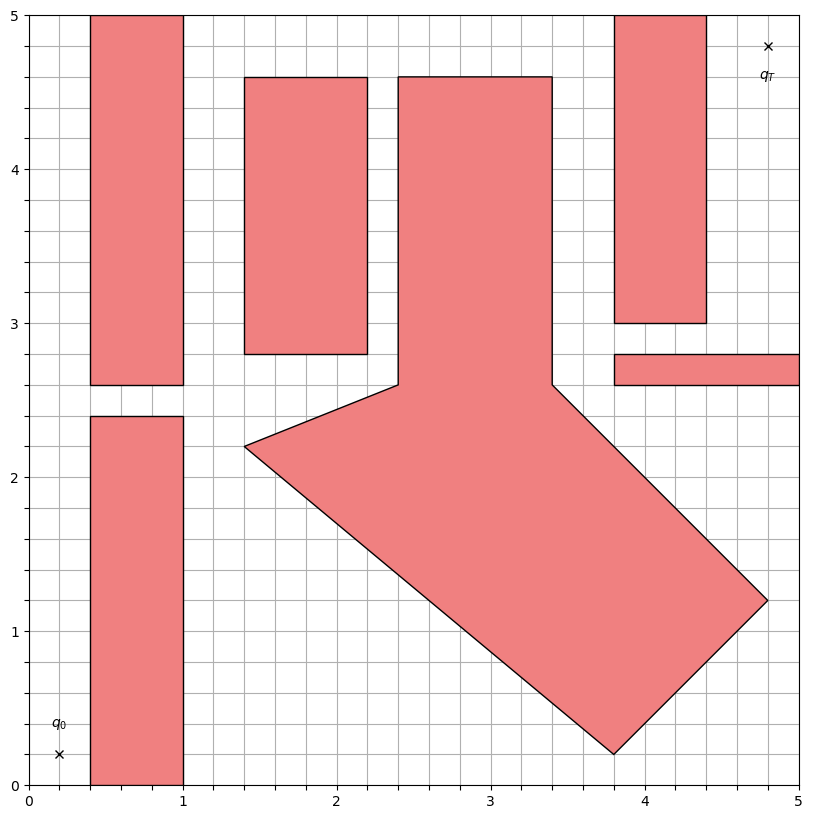

In [3]:
environment_setup()

for O in obstacles:
    plt.fill(*O.T, fc="lightcoral", ec="k", zorder=4)

plt.plot(*x_start, "kx")
plt.plot(*x_goal, "kx")

plt.text(0.2, 0.35, "$q_0$", ha="center", va="bottom")
plt.text(4.8, 4.65, "$q_T$", ha="center", va="top")

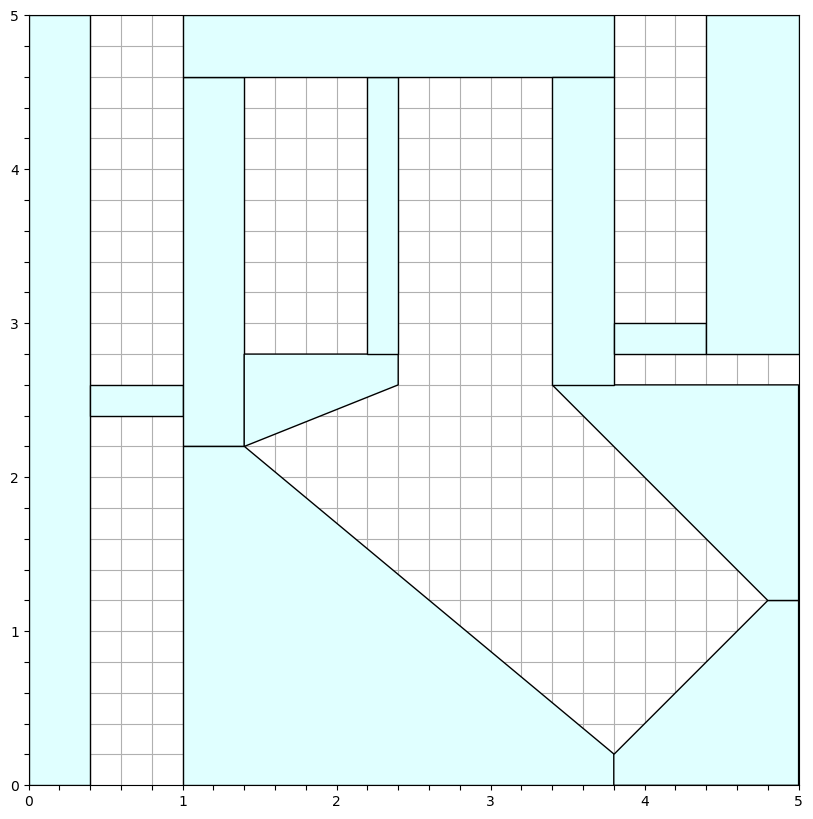

In [4]:
environment_setup()

for V in vertices:
    plt.fill(*V.T, fc="lightcyan", ec="k", zorder=4)

# Minimum-distance problem

In [11]:
def plot_trajectory(traj):
    plt.figure(figsize=(10, 10))

    for O in obstacles:
        plt.fill(*O.T, fc="lightsalmon", ec="k", zorder=4)

    plt.plot(*traj.value(traj.start_time()), "kx")
    plt.plot(*traj.value(traj.end_time()), "kx")
    times = np.linspace(traj.start_time(), traj.end_time(), 1000)
    waypoints = traj.vector_values(times)
    plt.plot(*waypoints, "b", zorder=5)

    plt.axis("square")
    plt.xlim([x_min[0], x_max[0]])
    plt.ylim([x_min[1], x_max[1]])
    plt.xticks(range(6))
    plt.yticks(range(6))
    plt.grid(1)

INFO:drake:Solved GCS shortest path using CSDP with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 100 rounding trials.


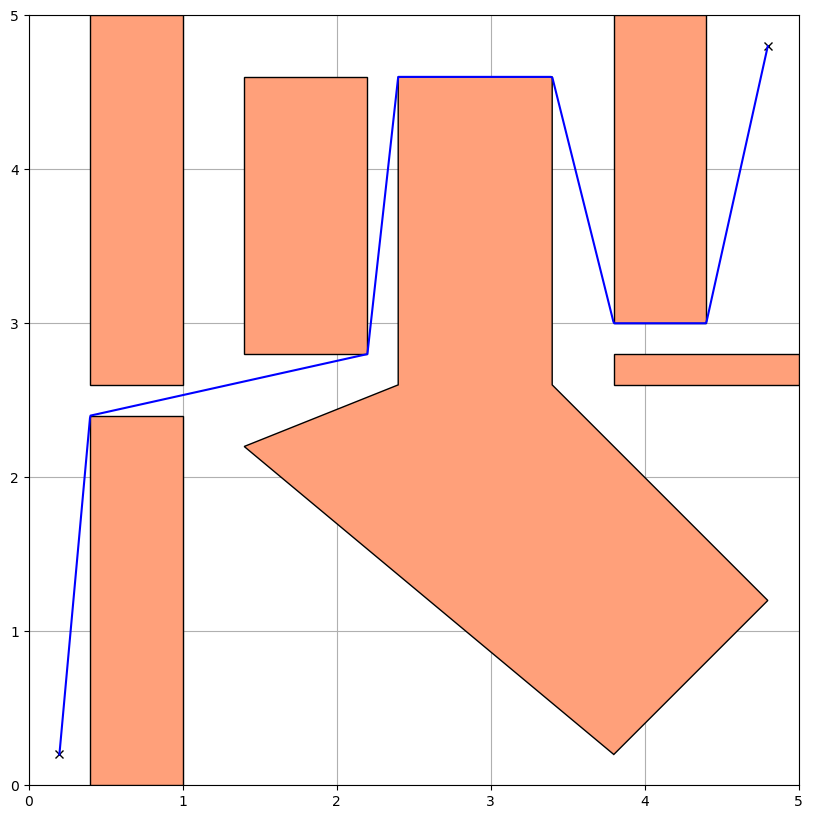

In [12]:
trajopt = GcsTrajectoryOptimization(2)
gcs_regions = trajopt.AddRegions(regions, order=1)
source = trajopt.AddRegions([Point(x_start)], order=0)
target = trajopt.AddRegions([Point(x_goal)], order=0)
trajopt.AddEdges(source, gcs_regions)
trajopt.AddEdges(gcs_regions, target)
trajopt.AddPathLengthCost()
options = GraphOfConvexSetsOptions()
options.convex_relaxation = True
[traj, result] = trajopt.SolvePath(source, target, options)
plot_trajectory(traj)

# Minimum-time problem

In [7]:
qdot_min = -1
qdot_max = 1


def solve_min_time(order, continuity_order):
    trajopt = GcsTrajectoryOptimization(2)
    gcs_regions = trajopt.AddRegions(regions, order=order)
    source = trajopt.AddRegions([Point(x_start)], order=0)
    target = trajopt.AddRegions([Point(x_goal)], order=0)
    trajopt.AddEdges(source, gcs_regions)
    trajopt.AddEdges(gcs_regions, target)
    trajopt.AddTimeCost()
    trajopt.AddVelocityBounds([qdot_min] * 2, [qdot_max] * 2)
    for o in range(1, continuity_order + 1):
        print(f"adding C{o} constraints")
        trajopt.AddPathContinuityConstraints(o)
    options = GraphOfConvexSetsOptions()
    options.convex_relaxation = True
    [traj, result] = trajopt.SolvePath(source, target, options)

    return traj, result

In [8]:
def plot_velocity(traj):
    vel = traj.MakeDerivative()

    plt.figure(figsize=(10, 8))

    for i in range(vel.get_number_of_segments()):
        v = vel.segment(i)
        times = np.linspace(v.start_time(), v.end_time(), 500)
        values = v.vector_values(times)
        plt.plot(times, values[0], color="tab:blue")
        plt.plot(times, values[1], color="tab:orange")

    plt.xlim([traj.start_time(), traj.end_time()])
    plt.xticks(np.arange(int(np.ceil(traj.end_time() / 2))) * 2)
    plt.yticks(np.linspace(qdot_min, qdot_max, 5))
    plt.xlabel("Time $t$")
    plt.ylabel("Velocity $\dot{q}$")
    plt.grid()

INFO:drake:Solved GCS shortest path using CLP with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 100 rounding trials.


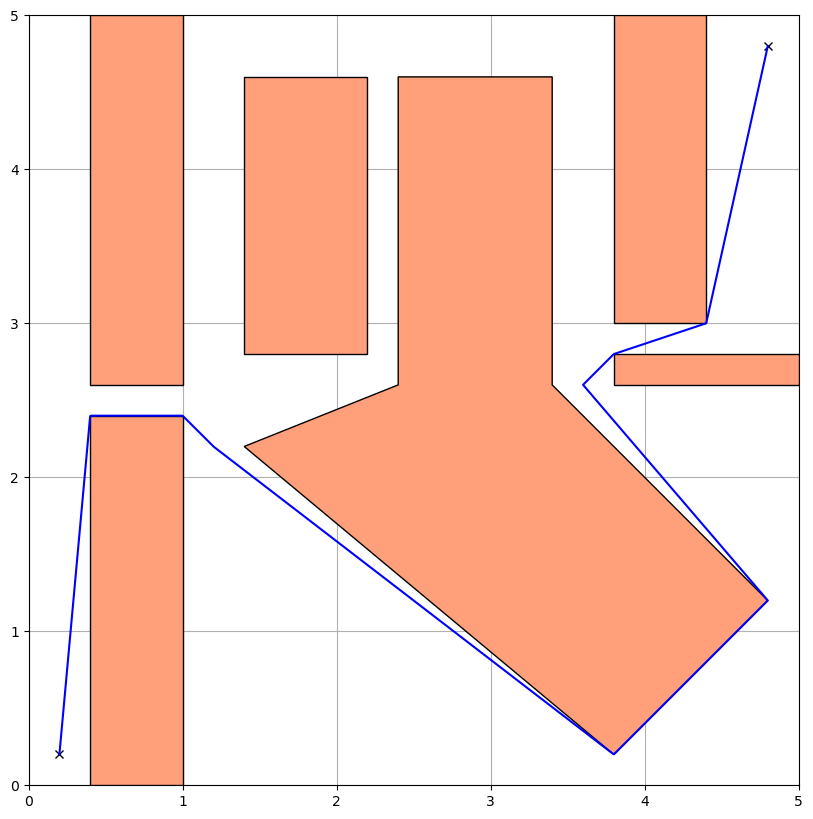

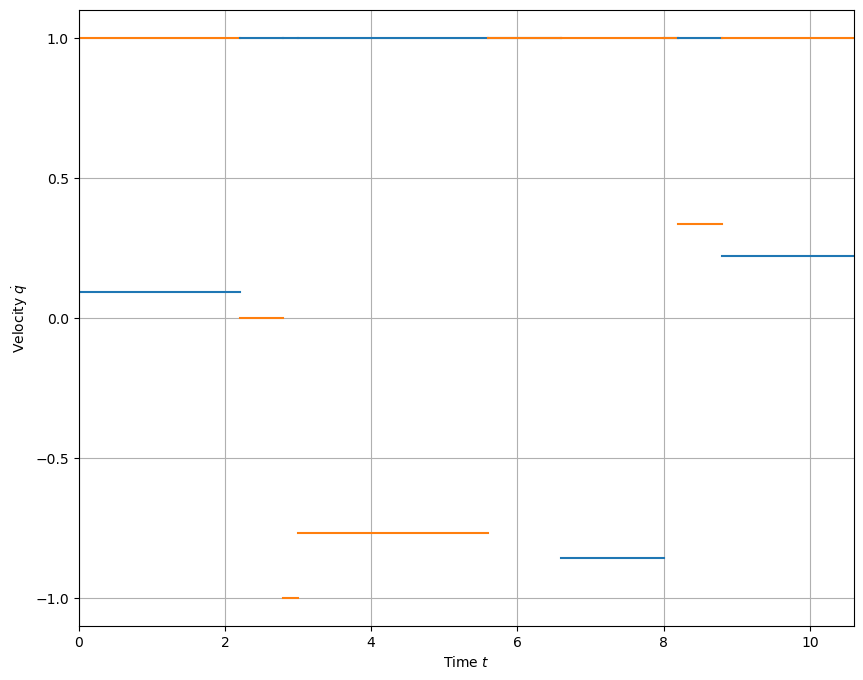

In [13]:
order = 1
continuity = 0
traj, results = solve_min_time(order, continuity)

plot_trajectory(traj)

plot_velocity(traj)

In [15]:
order = 6
continuity = 2
# regularizer = [1e-1, 1e-1]
traj, results = solve_min_time(order, continuity)

plot_trajectory(traj)

plot_velocity(traj)

path = GcsTrajectoryOptimization.NormalizeSegmentTimes(traj)
plot_velocity(path)
plt.ylabel("Path Velocity $\dot{r}$")

INFO:drake:Solved GCS shortest path using CLP with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 100 rounding trials.
adding C1 constraints
adding C2 constraints


Text(0, 0.5, 'Path Velocity $\\dot{r}$')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=06109659-1ce1-4127-8d4c-0eb734b835d4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>